In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
import sys
sys.path.append('../') # go to parent dir
sys.path.append('/home/artem/git/sdafe')

In [3]:
from sdafe.plot import plot_qq_norm
from sdafe.r import fv, tl, el
from sdafe.ch07.multivariate import fit_mvt
from sdafe.ch19.risk import VaR_t, ES_t, VaR_norm, ES_norm
from sdafe.ch19.tail_index import hill_curve

In [4]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, numpy2ri, default_converter

np_cv_rules = default_converter + numpy2ri.converter

### 19.11.1 Univariate VaR and ES

In [5]:
data = pd.read_csv('../data/CokePepsi.csv', sep='\\s+')
data.head()

,KO.Adjusted,PEP.Adjusted
0,20.52,53.31
1,20.53,53.67
2,20.39,53.50
3,20.52,53.62
4,20.54,53.84


In [6]:
price = data['KO.Adjusted']
ret = price.pct_change().dropna()

In [7]:
price

0       20.52
1       20.53
2       20.39
3       20.52
4       20.54
        ...  
1472    37.42
1473    36.72
1474    36.36
1475    36.29
1476    36.08
Name: KO.Adjusted, Length: 1477, dtype: float64

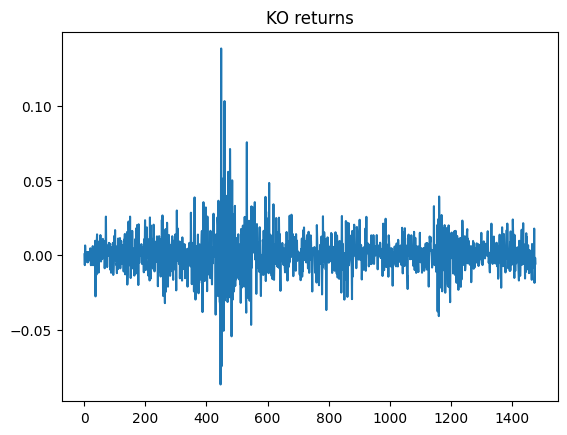

In [8]:
fig, ax = plt.subplots()
ax.plot(ret);
ax.set_title('KO returns');

In [9]:
fit = stats.t.fit(ret)
fit

(3.087006854390861, 0.0005453564371979491, 0.008324591226676198)

In [10]:
S = 4000
alpha = 0.05

#### Problem 1

The $\alpha$-quantile of the fitted t-distribution:

In [11]:
q = stats.t.ppf(alpha, df=fit[0])
q

-2.3265671511067914

The PDF of the fitted t-distribution evaluated at the $\alpha$-quantile:

In [12]:
p = stats.t.pdf(q, df=fit[0])
p

0.04649456932837549

#### Problem 2

The estimate of VaR is:

In [13]:
VaR_t(*fit, alpha, S)

75.28945622871473

The estimate of ES is:

In [14]:
ES_t(*fit, alpha, S)

123.92760154009827

#### Problem 3

We fit the following ARMA(0, 0)+GARCH(1, 1) model:
$$
\begin{equation}
\begin{split}
r_t &=& \mu + a_t \\
a_t &=& \epsilon_t \sigma_t \\
\sigma_t^2 &=& \omega + \alpha_1 a_{t-1}^2 + \beta_1 \sigma_{t-1}^2,
\end{split}
\end{equation}
$$
where $\epsilon_t$ has t-distribution with $\nu$ degrees of freedom.

In [15]:
rugarch = importr('rugarch')
rmethods = importr('methods')
rstats = importr('stats')

In [16]:
spec = rugarch.ugarchspec(mean_model=tl({'armaOrder': fv(0, 0)}), variance_model=tl({'garchOrder': fv(1, 1)}), distribution_model="std")
with np_cv_rules.context():
    fit = rugarch.ugarchfit(data=ret.values, spec=spec)
    pred = rugarch.ugarchforecast(fit, data=ret.values, n_ahead=1)
rmethods.show(fit);


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000675    0.000240  2.81442 0.004887
omega   0.000003    0.000004  0.80152 0.422833
alpha1  0.093818    0.034957  2.68381 0.007279
beta1   0.892159    0.038578 23.12598 0.000000
shape   5.889673    1.095606  5.37572 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.000675    0.000257  2.62791 0.008591
omega   0.000003    0.000016  0.17396 0.861894
alpha1  0.093818    0.148004  0.63389 0.526154
beta1   0.892159    0.169003  5.27894 0.000000
shape   5.889673    2.468554  2.38588 0.017038

LogLikelihood : 4596.056 

Information Criteria
------------------------------------
                 

#### Problem 4

The one-step ahead predictions of the conditional mean and standard deviation are:

In [17]:
mu = el(pred.slots['forecast'], 'seriesFor')[0]
mu

0.0006752321843790069

In [18]:
sd = el(pred.slots['forecast'], 'sigmaFor')[0]
sd

0.010382744027570273

#### Problem 5

The estimated one-day VaR(0.05) is

In [19]:
nu = el(fit.slots['fit'], 'coef')[4]

In [20]:
scale = sd / np.sqrt(nu / (nu - 2))

In [21]:
VaR_t(nu, mu, scale, 0.05, 4000)

63.10348763170147

The estimated one-day ES(0.05) is:

In [22]:
ES_t(nu, mu, scale, 0.05, 4000)

89.32590213767732

### 19.11.2 VaR Using a Multivariate-t Model

In [23]:
data = pd.read_csv('../data/berndtInvest.csv', index_col=0, parse_dates=[0])
data.head()

,CITCRP,CONED,CONTIL,DATGEN,DEC,DELTA,GENMIL,GERBER,IBM,MARKET,MOBIL,PANAM,PSNH,TANDY,TEXACO,WEYER,RKFREE
X.Y..m..d,,,,,,,,,,,,,,,,,
1978-01-01,-0.115,-0.079,-0.129,-0.084,-0.100,-0.028,-0.099,-0.048,-0.029,-0.045,-0.046,0.025,-0.008,-0.075,-0.054,-0.116,0.00487
1978-02-01,-0.019,-0.003,0.037,-0.097,-0.063,-0.033,0.018,0.160,-0.043,0.010,-0.017,-0.073,-0.025,-0.004,-0.010,-0.135,0.00494
1978-03-01,0.059,0.022,0.003,0.063,0.010,0.070,-0.023,-0.036,-0.063,0.050,0.049,0.184,0.026,0.124,0.015,0.084,0.00526
1978-04-01,0.127,-0.005,0.180,0.179,0.165,0.150,0.046,0.004,0.130,0.063,0.077,0.089,-0.008,0.055,0.000,0.144,0.00491
1978-05-01,0.005,-0.014,0.061,0.052,0.038,-0.031,0.063,0.046,-0.018,0.067,-0.011,0.082,0.019,0.176,-0.029,-0.031,0.00513


In [24]:
ret = data[['DATGEN', 'DEC']]

In [25]:
fit = fit_mvt(ret, mu_bounds=(-0.05, 0.05), a_bounds=(-0.5, 0.5), df_bounds=(2, 15))
fit

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -222.25234328005212
        x: [ 5.422e-03  2.164e-02  9.991e-02  4.546e-02  5.772e-02
             4.295e+00]
      nit: 24
      jac: [-1.588e-02 -4.988e-03 -3.087e-03 -1.379e-02 -1.019e-02
             1.990e-05]
     nfev: 196
     njev: 28
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

#### Prpoblem 6

The estimates of means are:

In [26]:
fit.x[:2]

array([0.00542233, 0.02164206])

The estimate of the scale matrix is:

In [27]:
A = np.zeros((2, 2))
A[np.triu_indices(2)] = fit.x[2:5]
A.T @ A

array([[0.00998277, 0.00454242],
       [0.00454242, 0.00539825]])

The estimate of the tail index is:

In [28]:
nu = fit.x[-1]
nu

4.295072981333025

The estimate of the covariance matrix:

In [29]:
Sigma = A.T @ A * nu / (nu - 2)
Sigma

array([[0.01868208, 0.00850084],
       [0.00850084, 0.01010245]])

The sample covariance matrix:

In [30]:
ret.cov()

,DATGEN,DEC
DATGEN,0.016266,0.007283
DEC,0.007283,0.009829


#### Problem 7

In [31]:
w = np.array([0.3, 0.7]).reshape(-1, 1)

(a) The distribution is univariate t with mean:

In [32]:
mu = (w.T @ fit.x[:2])[0]
mu

0.016776138621595764

and standard deviation:

In [33]:
sd = np.sqrt((w.T @ Sigma @ w)[0, 0])
sd

0.10100465186972196

(b) The estimate of VaR for this portfolio:

In [34]:
scale = sd / np.sqrt(nu / (nu - 2))

In [35]:
VaR_est = VaR_t(nu, mu, scale, 0.05, 100_000)
VaR_est

13756.973753373944

The estimate of ES for this portfolio:

In [36]:
ES_t(nu, mu, scale, 0.05, 100_000)

21129.21519920964

#### Problem 8

In [37]:
def boot_VaR(n_boot, ret, w, alpha, S, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    
    n = ret.shape[1]
    n_mu = n
    n_cov = n * (n + 1) // 2
    
    VaRs = np.zeros(n_boot)
    nus = np.zeros(n_boot)
    for i in range(n_boot):
        sample = ret.sample(frac=1, axis=0, replace=True, random_state=rng)
        fit = fit_mvt(sample, mu_bounds=(-0.05, 0.05), a_bounds=(-0.5, 0.5), df_bounds=(2, 15))
        mu = (w.T @ fit.x[:n_mu])[0]
        A = np.zeros((n, n))
        A[np.triu_indices(n)] = fit.x[n_mu:n_mu + n_cov]
        scale = np.sqrt(w.T @ A.T @ A @ w)
        nu = fit.x[-1]
        VaRs[i] = VaR_t(nu, mu, scale, alpha, S)
        nus[i] = nu

    return VaRs, nus

In [38]:
n_boot = 250

In [39]:
rng = np.random.default_rng(12345)
VaRs, nus = boot_VaR(n_boot, ret, w, 0.05, 100_000, rng=rng)

In [40]:
boot_alpha = 0.1

The basic confidence interval for VaR is:

In [41]:
2 * VaR_est - np.quantile(VaRs, [(1 + boot_alpha) / 2, (1 - boot_alpha) / 2])

array([13712.85848149, 14126.24287433])

The density of the VaR estimates appears reasonably Gaussian based on the histogram, whereas the density of $\nu$ is obviously skewed:

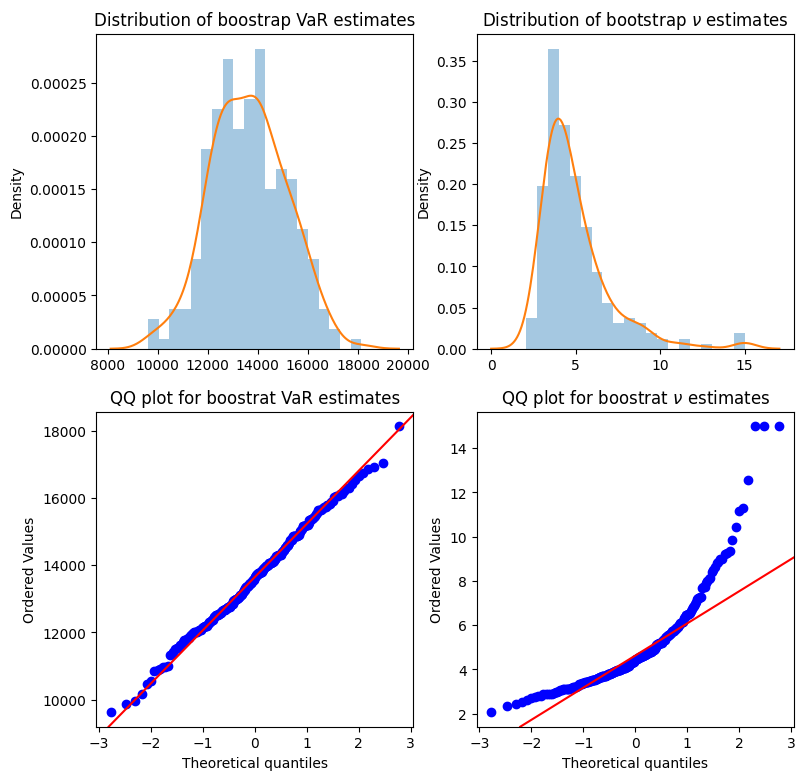

In [46]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))

# histogram of VaR values
axs[0][0].hist(VaRs, bins=20, density=True, alpha=0.4);
axs[0][0].set_title('Distribution of boostrap VaR estimates');

# KDE of VaR values
sns.kdeplot(VaRs, ax=axs[0][0]);

# histogram of nu
axs[0][1].hist(nus, bins=20, density=True, alpha=0.4);
axs[0][1].set_title('Distribution of bootstrap $\\nu$ estimates');

# KDE of nu
sns.kdeplot(nus, ax=axs[0][1]);

plot_qq_norm(axs[1][0], VaRs);
axs[1][0].set_title('QQ plot for boostrat VaR estimates');

plot_qq_norm(axs[1][1], nus);
axs[1][1].set_title('QQ plot for boostrat $\\nu$ estimates');

#### Problem 9

In [43]:
def unzip(x: np.array):
    return x[:, 0], x[:, 1]

In [44]:
c, nc, a = hill_curve(ret['DEC'])

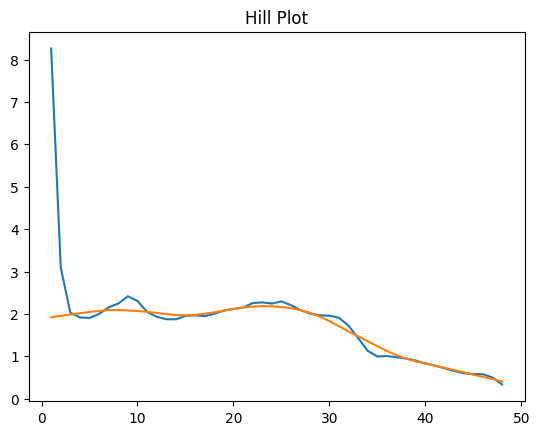

In [45]:
fig, ax = plt.subplots()
ax.plot(nc, a);
ax.plot(*unzip(lowess(a, nc, frac=0.3)));
ax.set_title('Hill Plot');

The estimate is quite stable in the region 5-25, so we can use the value of 2 as the estimate.